In [1]:
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from astropy.stats import median_absolute_deviation as MAD
from scipy.stats import binned_statistic, binned_statistic_2d
from scipy.ndimage import gaussian_filter
from pyia import GaiaData

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic
from gala.mpl_style import *

# from totoro.potentials import get_equivalent_galpy
# from totoro.actions_staeckel import get_staeckel_aaf
# from tqdm.notebook import tqdm, trange

In [2]:
with coord.galactocentric_frame_defaults.set('v4.0'):
    galcen_frame = coord.Galactocentric()
    
mw_pot = gp.MilkyWayPotential()

In [3]:
# w0_sun = coord.SkyCoord(0*u.deg, 0*u.deg, 
#                         distance=1e-5*u.pc, 
#                         pm_ra_cosdec=0*u.mas/u.yr,
#                         pm_dec=0*u.mas/u.yr,
#                         radial_velocity=0*u.km/u.s)
# w0_sun = gd.PhaseSpacePosition(w0_sun.transform_to(galcen_frame).data)
# orbit = mw_pot.integrate_orbit(w0_sun, dt=0.1*u.Myr, t1=0, t2=200*u.Myr)

# fig = plt.figure(figsize=(8, 6))
# plt.plot(orbit.t, orbit.spherical.distance)
# plt.ylabel('Gal. cen. distance, $r$ [kpc]')
# plt.xlabel('time, $t$ [Myr]')
# fig.set_facecolor('w')

In [4]:
allstar_edr3 = at.Table.read('/mnt/home/apricewhelan/data/APOGEE_beta/allStar-r13-l33-58932beta-gaiaedr3.fits')

In [5]:
dist_tbl = at.Table.read('/mnt/home/apricewhelan/data/APOGEE_beta/spDistances_ARA_58932beta.fits')

In [6]:
actions_tbl = at.QTable.read(
    '/mnt/home/apricewhelan/data/APOGEE_beta/allStar-r13-l33-58932beta-edr3-spDistances-actions.fits')

In [7]:
tbl = at.join(allstar_edr3, dist_tbl, keys='APOGEE_ID')
tbl = at.join(tbl, actions_tbl, keys='APOGEE_ID')
tbl = at.QTable(at.unique(tbl, keys='APOGEE_ID'))

In [8]:
hayes_odisk = at.Table.read('../../dr2-low-latitude-structures/data/hayes_odisk_mem_nosgr.txt', 
                            format='ascii.commented_header')
hayes_odisk.rename_column('APOID', 'APOGEE_ID')

In [9]:
_triand_mask = np.array(['TriAnd1' in x or 'TriAnd2' in x 
                         for x in hayes_odisk['GROUP']])
_a13_mask = np.array(['A13' in x for x in hayes_odisk['GROUP']])
_gass_mask = np.array(['GASS' in x for x in hayes_odisk['GROUP']])

triand_mask = np.isin(
    tbl['APOGEE_ID'].astype(str), 
    hayes_odisk['APOGEE_ID'][_triand_mask])

a13_mask = np.isin(
    tbl['APOGEE_ID'].astype(str), 
    hayes_odisk['APOGEE_ID'][_a13_mask])

gass_mask = np.isin(
    tbl['APOGEE_ID'].astype(str), 
    hayes_odisk['APOGEE_ID'][_gass_mask])

In [10]:
g = GaiaData(tbl)
c = g.get_skycoord(
    distance=g.D2_med*u.kpc, 
    radial_velocity=g.VHELIO_AVG*u.km/u.s)

In [62]:
gal = c.galactic

In [11]:
np.isfinite(g.D1_med).sum(), np.isfinite(g.D2_med).sum()

(523206, 539104)

In [12]:
galcen = c.transform_to(galcen_frame)
w0 = gd.PhaseSpacePosition(galcen.data)
cyl = w0.cylindrical

In [52]:
vrho = cyl.v_rho
vphi = (cyl.rho * cyl.pm_phi).to(u.km/u.s, u.dimensionless_angles())
vz = cyl.v_z

R = cyl.rho
z = cyl.z

In [18]:
Lz = w0.angular_momentum()[2]

In [19]:
# tmp = np.zeros((3, cyl.shape[0]))
# tmp[0] = cyl.rho.to_value(u.kpc)
# dPhi_dR = mw_pot.gradient(tmp)[0]
# Rg = np.cbrt(Lz**2 / dPhi_dR).to(u.kpc)

vcirc = mw_pot.circular_velocity(w0)
Rg = R * -vphi / vcirc

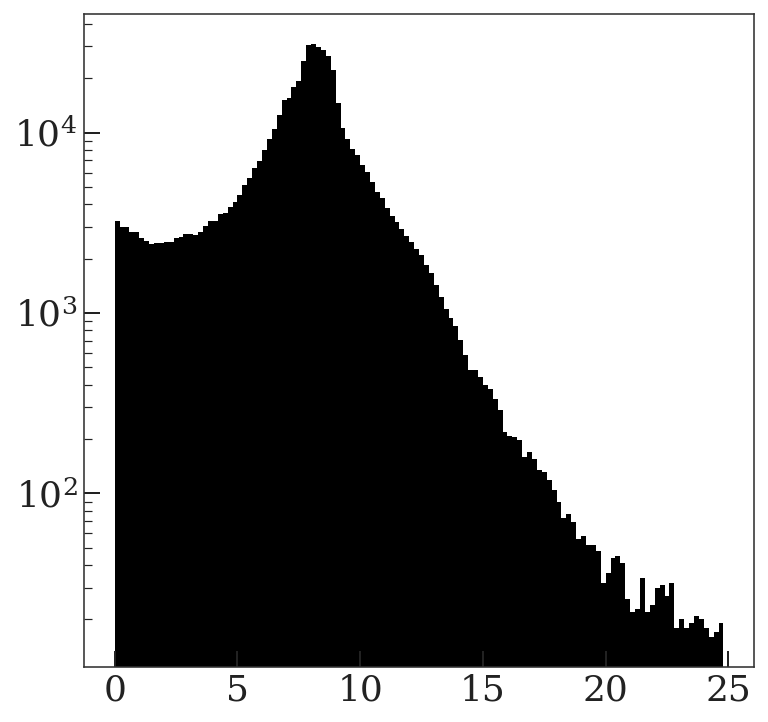

In [20]:
plt.hist(Rg.value, bins=np.arange(0, 25, 0.2))
plt.yscale('log');

## Select RGB stars and the low-alpha sequence:

(borrowed from `totoro`)

In [21]:
from matplotlib.path import Path

In [75]:
t = g.data

aspcap_bitmask = np.sum(2 ** np.array([
    # 7,  # STAR_WARN
    23  # STAR_BAD
]))
quality_mask = (
    (t['SNR'] > 20) &
    ((t['ASPCAPFLAG'] & aspcap_bitmask) == 0)
)

# Remove stars targeted in known clusters or dwarf galaxies:
mask_bits = {
    'APOGEE_TARGET1': np.array([9, 18, 24, 26]),
    'APOGEE_TARGET2': np.array([10, 18]),
    'APOGEE2_TARGET1': np.array([9, 18, 20, 21, 22, 23, 24, 26]),
    'APOGEE2_TARGET2': np.array([10]),
    'APOGEE2_TARGET3': np.array([5, 14, 15])
}
target_mask = np.ones(len(t), dtype=bool)
for name, bits in mask_bits.items():
    target_mask &= (t[name] & np.sum(2**bits)) == 0

target_mask &= np.isin(g.TELESCOPE.astype(str), ['apo25m', 'lco25m'])

# outer galaxy:
l_mask = np.abs(cyl.phi) > 90*u.deg
    
# low disk height
z_mask = np.abs(cyl.z) < 12*u.kpc

init_mask = quality_mask & target_mask & l_mask & z_mask

_mh_alpham_nodes = np.array([
    [0.6, -0.05],
    [0.6, 0.04],
    [0.15, 0.04],
    [-0.5, 0.13],
    [-0.9, 0.13],
    [-1., 0.07],
    [-0.2, -0.1],
    [0.2, -0.1],
    [0.6, -0.05]]
)
mh_alpham_path = Path(_mh_alpham_nodes[:-1])
low_alpha_mask = init_mask & mh_alpham_path.contains_points(
    np.stack((t['M_H'], t['ALPHA_M'])).T)

hi_alpha_mask = init_mask & (~low_alpha_mask) & (t['M_H'] > -1.) & (t['ALPHA_M'] > 0.1)

# RGB
bounds = {
    'LOGG': (0.5, 3.7),
    'TEFF': (3500, 6000),
    'FE_H': (-3, 1)
}

# MS
# bounds = {
#     'LOGG': (3.7, 5.5),
#     'TEFF': (3900, 7200),
#     'M_H': (-3, 1)
# }
rgb_mask = init_mask
for k, (l, r) in bounds.items():
    rgb_mask &= (t[k] > l) & (t[k] <= r)
    
apogee_mask = rgb_mask & low_alpha_mask
    
apogee_mask.sum(), rgb_mask.sum(), (rgb_mask & low_alpha_mask).sum(), (rgb_mask & hi_alpha_mask).sum()

(202052, 293230, 202052, 71811)

(5.5, 0.0)

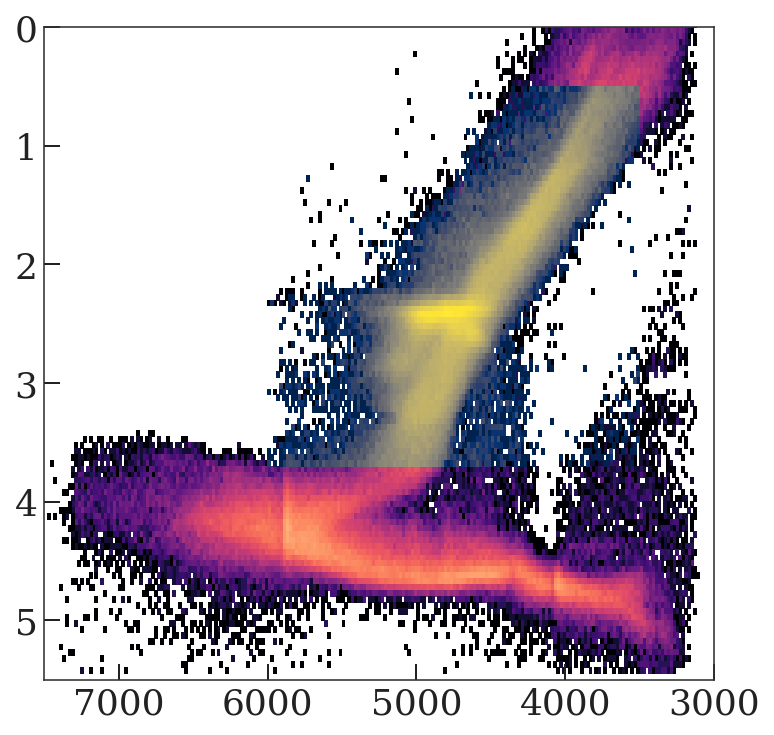

In [76]:
plt.hist2d(tbl['TEFF'], tbl['LOGG'],
          bins=(np.arange(3000, 7500, 20),
                np.arange(-0.2, 5.5, 0.05)),
          norm=mpl.colors.LogNorm());
plt.hist2d(tbl['TEFF'][rgb_mask], 
           tbl['LOGG'][rgb_mask],
          bins=(np.arange(3000, 7500, 20),
                np.arange(-0.2, 5.5, 0.05)),
          norm=mpl.colors.LogNorm(), cmap='cividis');
plt.xlim(7500, 3000)
plt.ylim(5.5, 0)

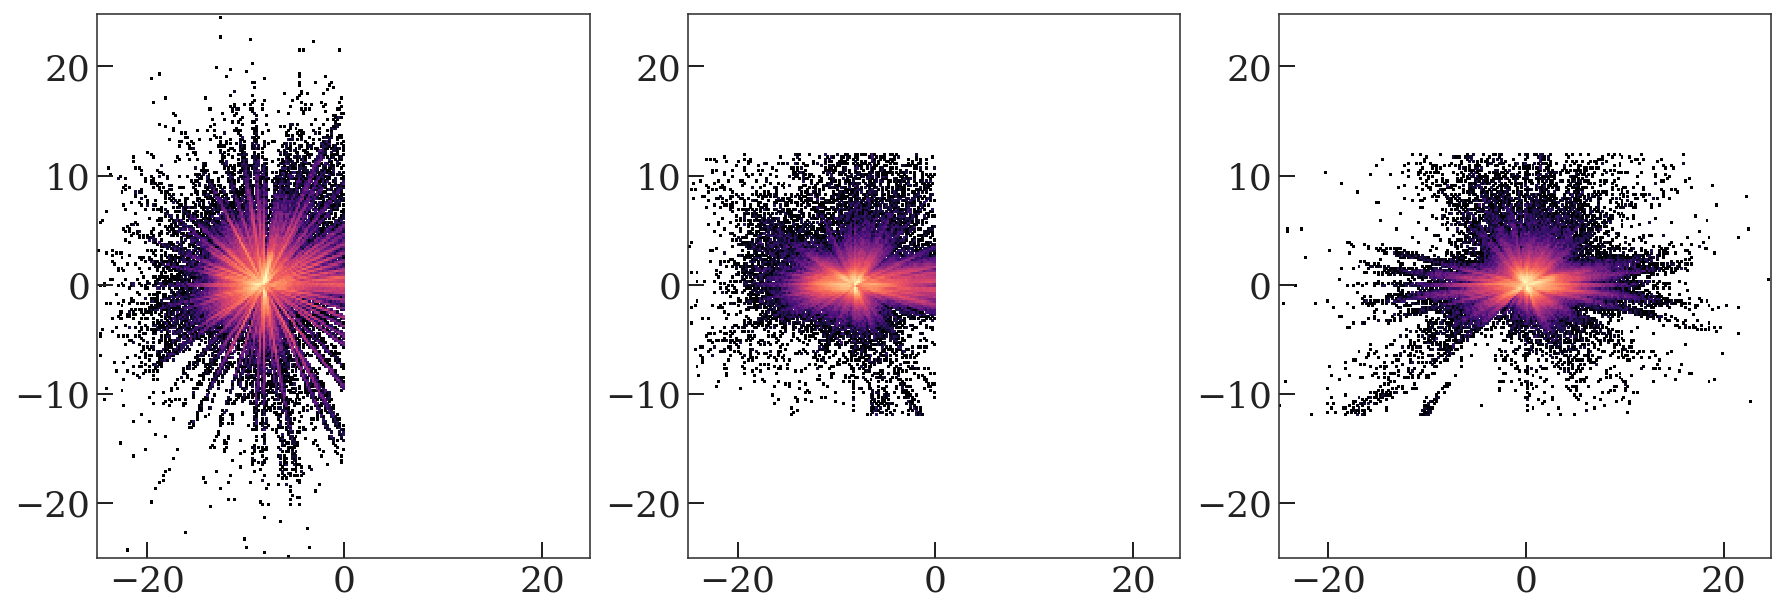

In [77]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

ax = axes[0]
ax.hist2d(w0.x.value[rgb_mask], w0.y.value[rgb_mask],
          bins=np.arange(-25, 25, 0.2),
          norm=mpl.colors.LogNorm());

ax = axes[1]
ax.hist2d(w0.x.value[rgb_mask], w0.z.value[rgb_mask],
          bins=np.arange(-25, 25, 0.2),
          norm=mpl.colors.LogNorm());

ax = axes[2]
ax.hist2d(w0.y.value[rgb_mask], w0.z.value[rgb_mask],
          bins=np.arange(-25, 25, 0.2),
          norm=mpl.colors.LogNorm());

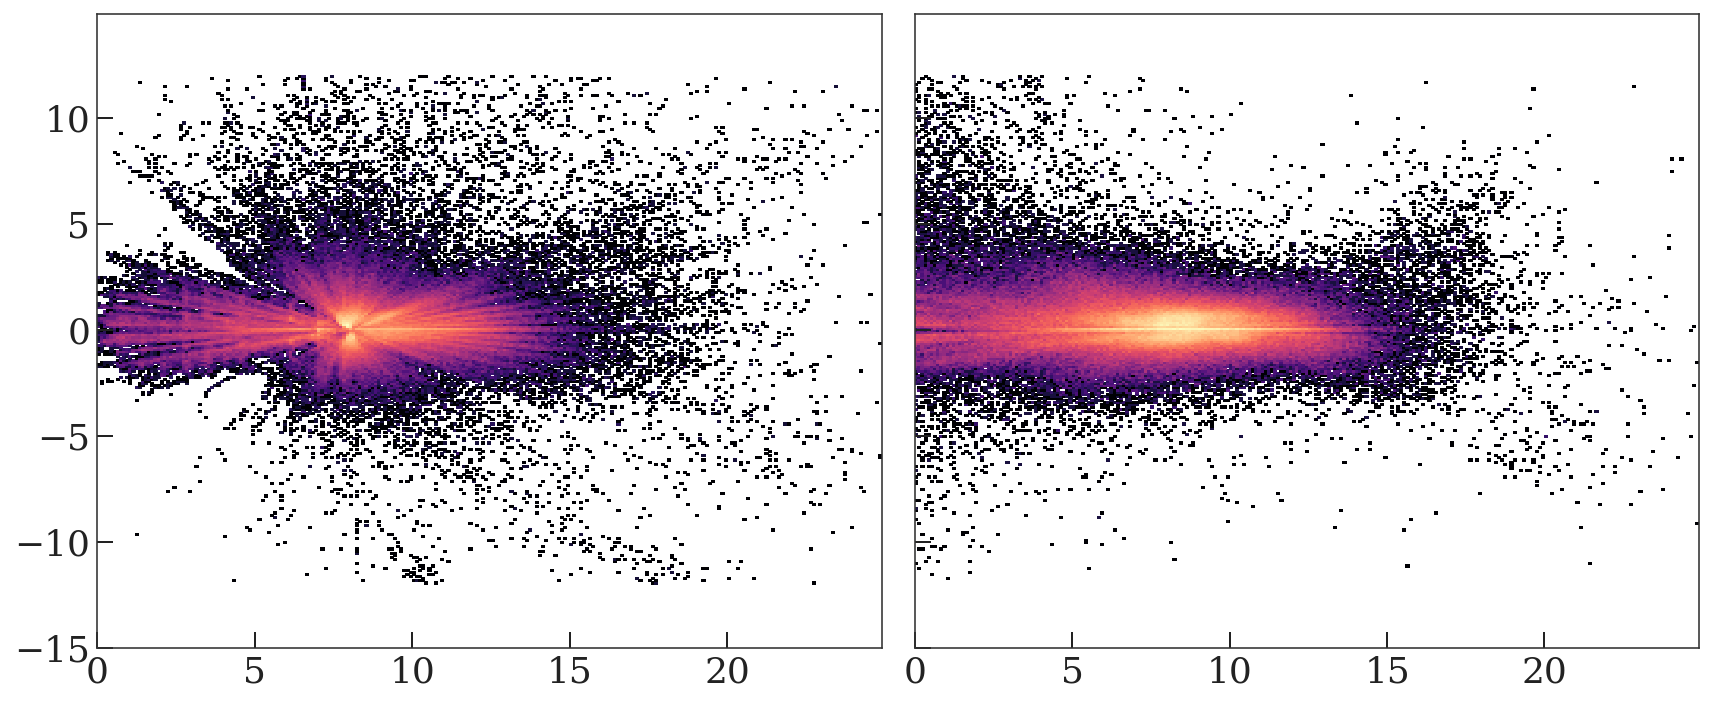

In [78]:
bins = (np.arange(0, 25, 0.1),
        np.arange(-15, 15, 0.1))

fig, axes = plt.subplots(1, 2, figsize=(12, 5), 
                         sharex=True, sharey=True)

ax = axes[0]
ax.hist2d(R.value[rgb_mask], z.value[rgb_mask],
          bins=bins,
          norm=mpl.colors.LogNorm());

ax = axes[1]
ax.hist2d(Rg.value[rgb_mask], z.value[rgb_mask],
          bins=bins,
          norm=mpl.colors.LogNorm());

fig.tight_layout()

(270.0, 90.0)

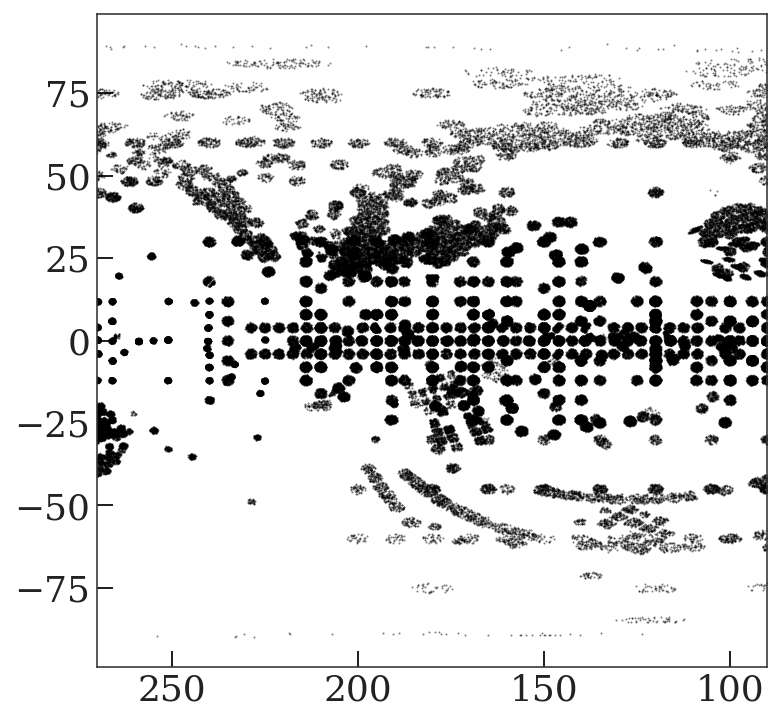

In [79]:
plt.plot(gal.l.wrap_at(360*u.deg).degree[rgb_mask], 
         gal.b.degree[rgb_mask], 
         ls='none', ms=1, marker='o', mew=0, alpha=0.5)
plt.xlim(270, 90)

In [80]:
g.data[rgb_mask].write('../data/APOGEE-Alvaro-EDR3-RGB.fits', 
                       overwrite=True)

## Trends with R

In [36]:
bins = np.arange(0, 22, 0.5)
ctr = 0.5 * (bins[:-1] + bins[1:])
# RR = Rg
RR = cyl.rho

mad_stats = {}
mean_stats = {}

coos = ['R', 'phi', 'z']
for name, vv in zip(coos, [vrho, vphi, vz]):
    mad_stats[name] = binned_statistic(
        RR.value[apogee_mask], 
        vv[apogee_mask].to_value(u.km/u.s),
        bins=bins, 
        statistic=MAD)

    mean_stats[name] = binned_statistic(
        RR.value[apogee_mask], 
        vv[apogee_mask].to_value(u.km/u.s),
        bins=bins)

In [37]:
mean_X_stats = {}

for name in ['M_H', 'MG_FE', 'C_FE']:
    abun_mask = tbl[name] > -5
    mean_X_stats[name] = binned_statistic(
        RR.value[apogee_mask & abun_mask], 
        tbl[name][apogee_mask & abun_mask],
        bins=bins)

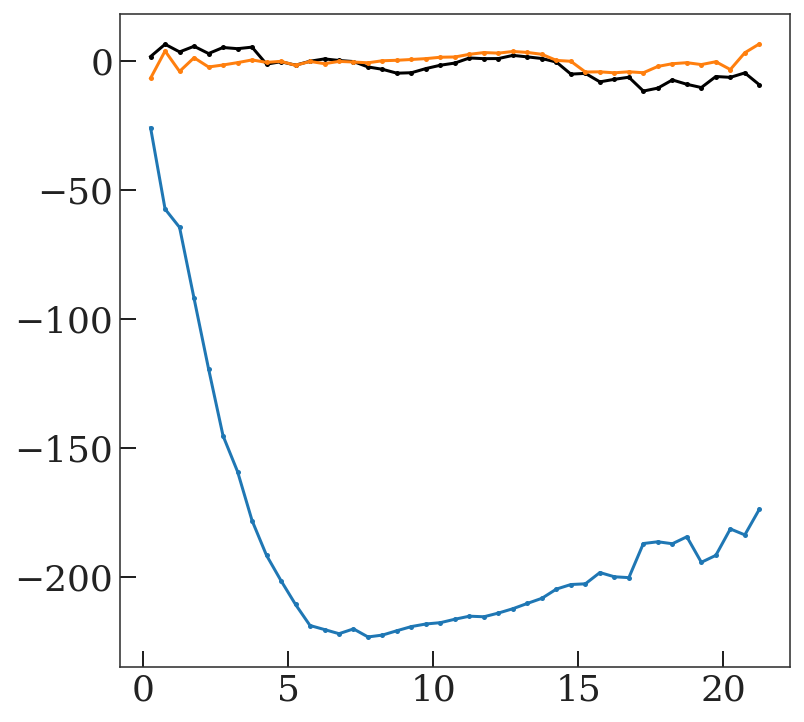

In [38]:
for name in mean_stats:
    plt.plot(ctr, mean_stats[name].statistic)

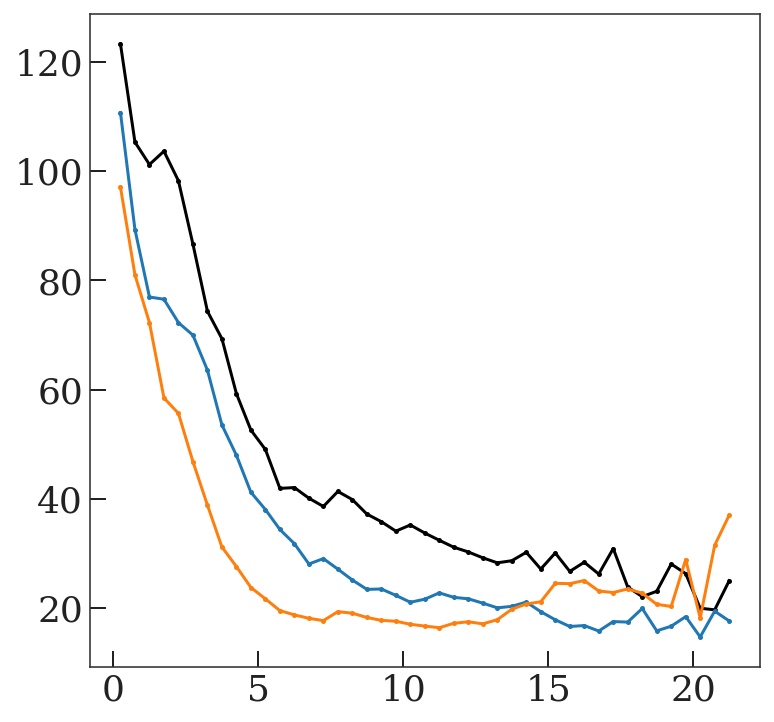

In [39]:
for name in mean_stats:
    plt.plot(ctr, 1.5 * mad_stats[name].statistic)

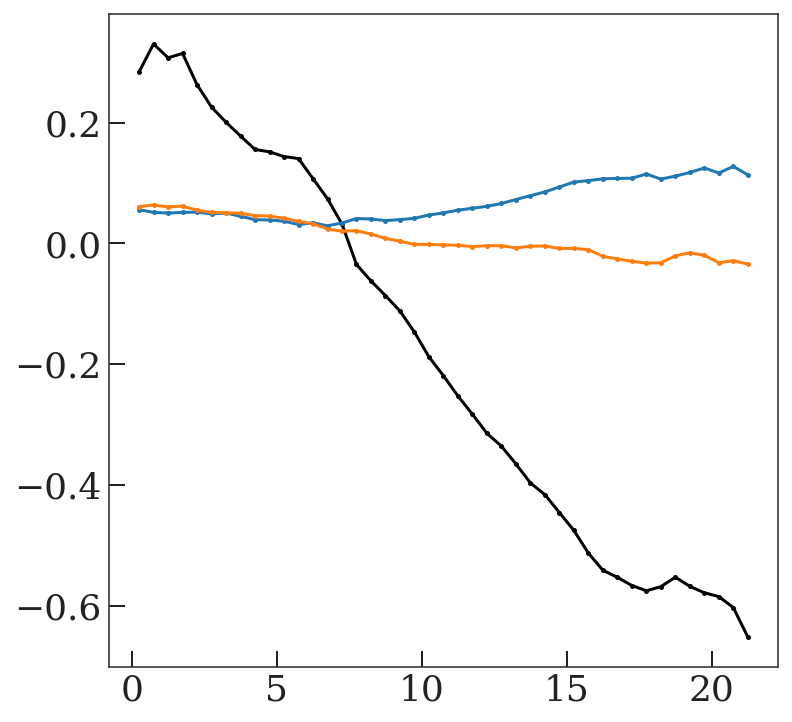

In [40]:
for name in mean_X_stats:
    plt.plot(ctr, mean_X_stats[name].statistic)

## Trends with actions

In [41]:
def edges_to_bins(edges):
    return np.stack((edges[:-1], edges[1:])).T


def make_panels(tt, x, y, xbins, ybins, xlabel, ylabel, 
                abun1='M_H', abun2='ALPHA_M',
                abun1_label=None, abun2_label=None,
                extra_mask=None, bins=None,
                point_masks=None,
                point_styles=None,
                flipud=False, cmap='cividis'):
    
    if abun1 == 'M_H' and abun1_label is None:
        abun1_label = '$[M/H]$'
    elif abun1_label is None and isinstance(abun1, str):
        nu, de = abun1.split('_')
        abun1_label = f'[{nu.capitalize()}/{de.capitalize()}]'
        
    if abun2 == 'ALPHA_M' and abun2_label is None:
        abun2_label = r'$[\alpha/M]$'
    elif abun2_label is None and isinstance(abun2, str):
        nu, de = abun2.split('_')
        abun2_label = f'[{nu.capitalize()}/{de.capitalize()}]'
    
    if isinstance(abun1, str):
        abun1 = tt[abun1] 
    if isinstance(abun2, str):
        abun2 = tt[abun2]
        
    if bins is None:
        bins = (np.arange(-2.5, 0.75, 0.02),
                np.arange(-0.2, 0.5, 0.01))
        
    if point_masks is None:
        point_masks = []
        
    if point_styles is None:
        point_styles = [dict()] * len(point_masks)
    for point_style in point_styles:
        point_style.setdefault('marker', 'o')
        point_style.setdefault('mew', 0)
        point_style.setdefault('ls', 'none')
        
    xlim = (bins[0].min(), bins[0].max())
    ylim = (bins[1].min(), bins[1].max())
    
    fig, axes = plt.subplots(len(ybins), len(xbins), 
                             figsize=(4 * len(xbins), 
                                      4 * len(ybins) * 0.75),
                             sharex=True, sharey=True,
                             constrained_layout=True)
    
    axes[-1, 0].set_xlabel(abun1_label, fontsize=26)
    axes[-1, 0].set_ylabel(abun2_label, fontsize=26)
    
    axes = np.flipud(axes)

    for i in range(len(ybins)):
        for j in range(len(xbins)):
            ax = axes[i, j]

            mask = ((x > xbins[j][0]) & (x < xbins[j][1]) & 
                    (y > ybins[i][0]) & (y < ybins[i][1]))
            
            if extra_mask is not None:
                mask &= extra_mask

            ax.hist2d(abun1[mask], abun2[mask],
                      bins=bins, norm=mpl.colors.LogNorm(vmin=0.5), 
                      cmap=cmap)
            
            for point_mask, style in zip(point_masks, point_styles):
                mask = ((x > xbins[j][0]) & (x < xbins[j][1]) & 
                        (y > ybins[i][0]) & (y < ybins[i][1])) & point_mask
                ax.plot(abun1[mask], abun2[mask],
                        **style)
            
            l, r = ybins[i]
            ax.text(xlim[1]-0.05, ylim[1]-0.05, f'${l:.1f} < {ylabel} < {r:.1f}$', 
                    ha='right', va='top', fontsize=18,
                    bbox=dict(facecolor='w', alpha=0.6))

            l, r = xbins[j]
            ax.text(xlim[0]+0.05, ylim[0]+0.05, f'${l:.1f} < {xlabel} < {r:.1f}$', 
                    ha='left', va='bottom', fontsize=18,
                    bbox=dict(facecolor='w', alpha=0.6))
    
    axes[0, 0].set_xlim(xlim)
    axes[0, 0].set_ylim(ylim)

    fig.set_facecolor('w')
    
    return fig, axes

In [42]:
def plot_mh_am_trends(axes, styles=None):
    if styles is None:
        styles = [dict(), dict()]
    
    base_styles = [dict(marker='', ls='--', color='tab:green', alpha=0.8, zorder=100, lw=2),
                   dict(marker='', ls='--', color='tab:red', alpha=0.8, zorder=100, lw=2)]
    for k, v in base_styles[0].items():
        styles[0].setdefault(k, v) 
    for k, v in base_styles[1].items():
        styles[1].setdefault(k, v) 
    
    xx = np.linspace(-2.5, 2, 128)
    for ax in axes:
        _mask = (xx > -2) & (xx < 0.)
        ax.plot(xx[_mask], 
                -0.11 * (xx[_mask] - 0) + 0.16,
                **styles[0])

        _mask = (xx > -1) & (xx < 0.75)
        ax.plot(xx[_mask], 
                -0.11 * (xx[_mask] - 0) + 0.01,
                **styles[1])

In [43]:
Jphi_scale = 229 * u.km/u.s * 8.178 * u.kpc
J_scale = 25 * u.km/u.s * 0.5 * u.kpc

jr = (tbl['J_R'] / J_scale).decompose()
jphi = (-tbl['J_phi'] / Jphi_scale).decompose()
jz = (tbl['J_z'] / J_scale).decompose()

## Rg and logJz

6 6


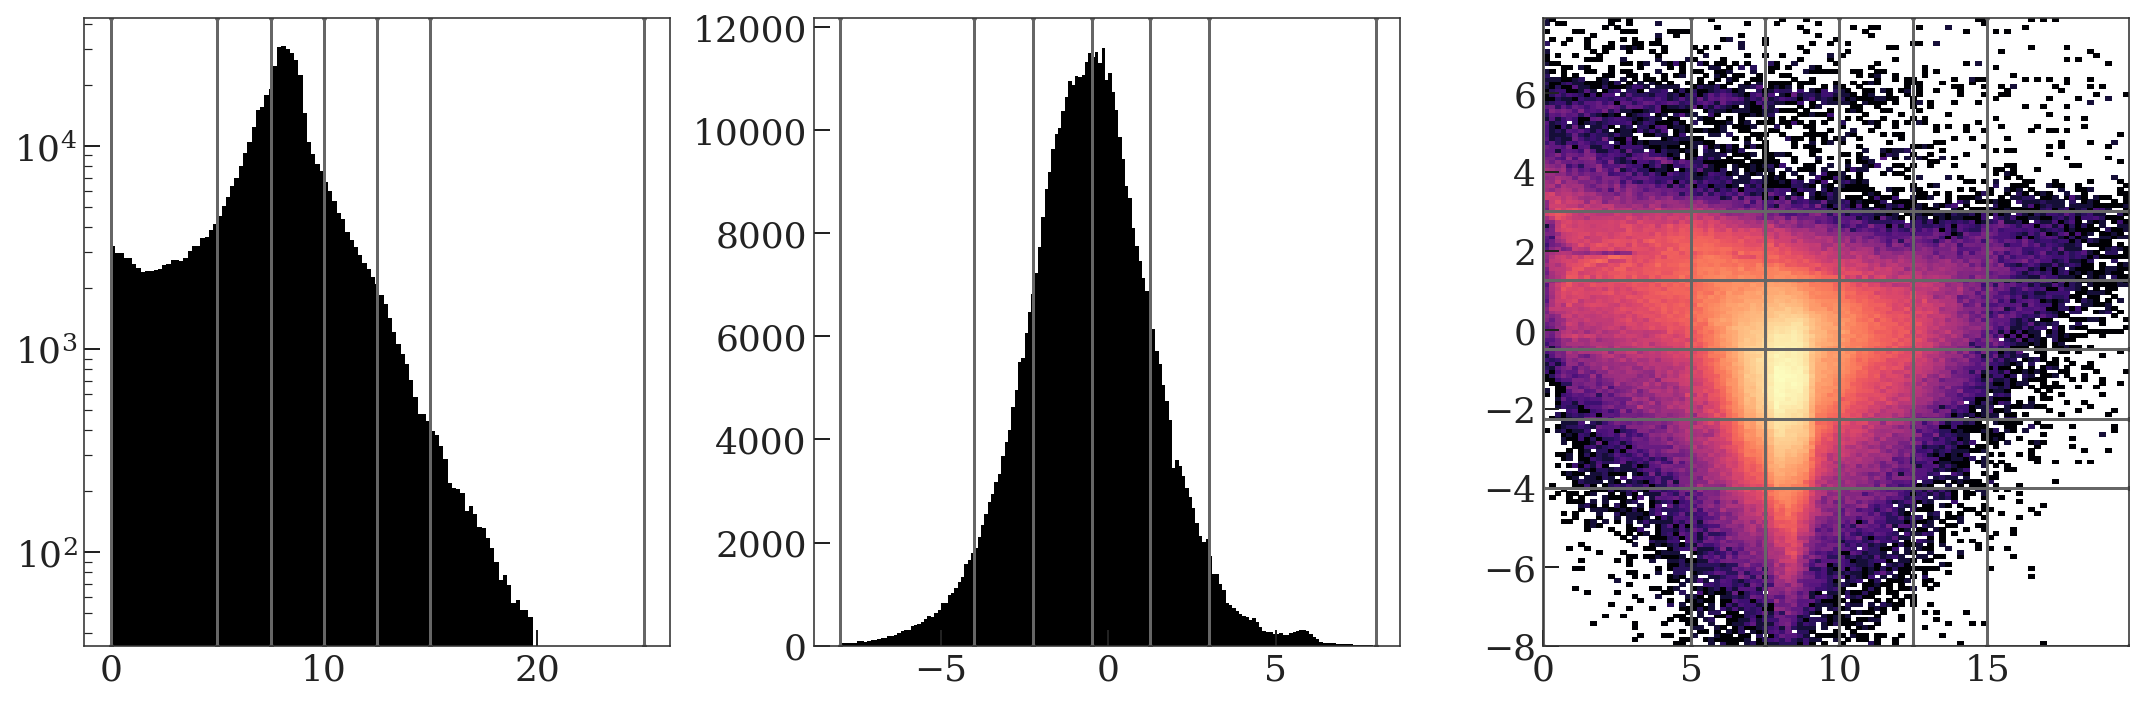

In [46]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Rg
ax = axes[0]
ax.hist(Rg.value, bins=np.arange(0, 20, 0.2));

# Rg_edges = np.arange(0, 20+1e-3, 4)
Rg_edges = np.concatenate(
    ([0], np.arange(5, 15+1e-3, 2.5), [25]))

for l in Rg_edges:
    ax.axvline(l)
ax.set_yscale('log')

# Jz
ax = axes[1]
logjz = np.log(jz)
ax.hist(logjz, bins=np.arange(-8, 8, 0.1));

logJz_edges = np.concatenate(
    ([-8], np.arange(-4, 4+1e-3, 1.75), [8]))
for l in logJz_edges:
    ax.axvline(l)
# ax.set_yscale('log')

# plot both:
ax = axes[2]

ax.hist2d(Rg.value, logjz, 
          bins=(np.arange(0, 20, 0.2), 
                np.arange(-8, 8, 0.1)),
          norm=mpl.colors.LogNorm())
    
for l in Rg_edges:
    ax.axvline(l)
for l in logJz_edges:
    ax.axhline(l)
    
fig.tight_layout()

Rg_bins = edges_to_bins(Rg_edges)
logjz_bins = edges_to_bins(logJz_edges)
print(len(Rg_bins), len(logjz_bins))

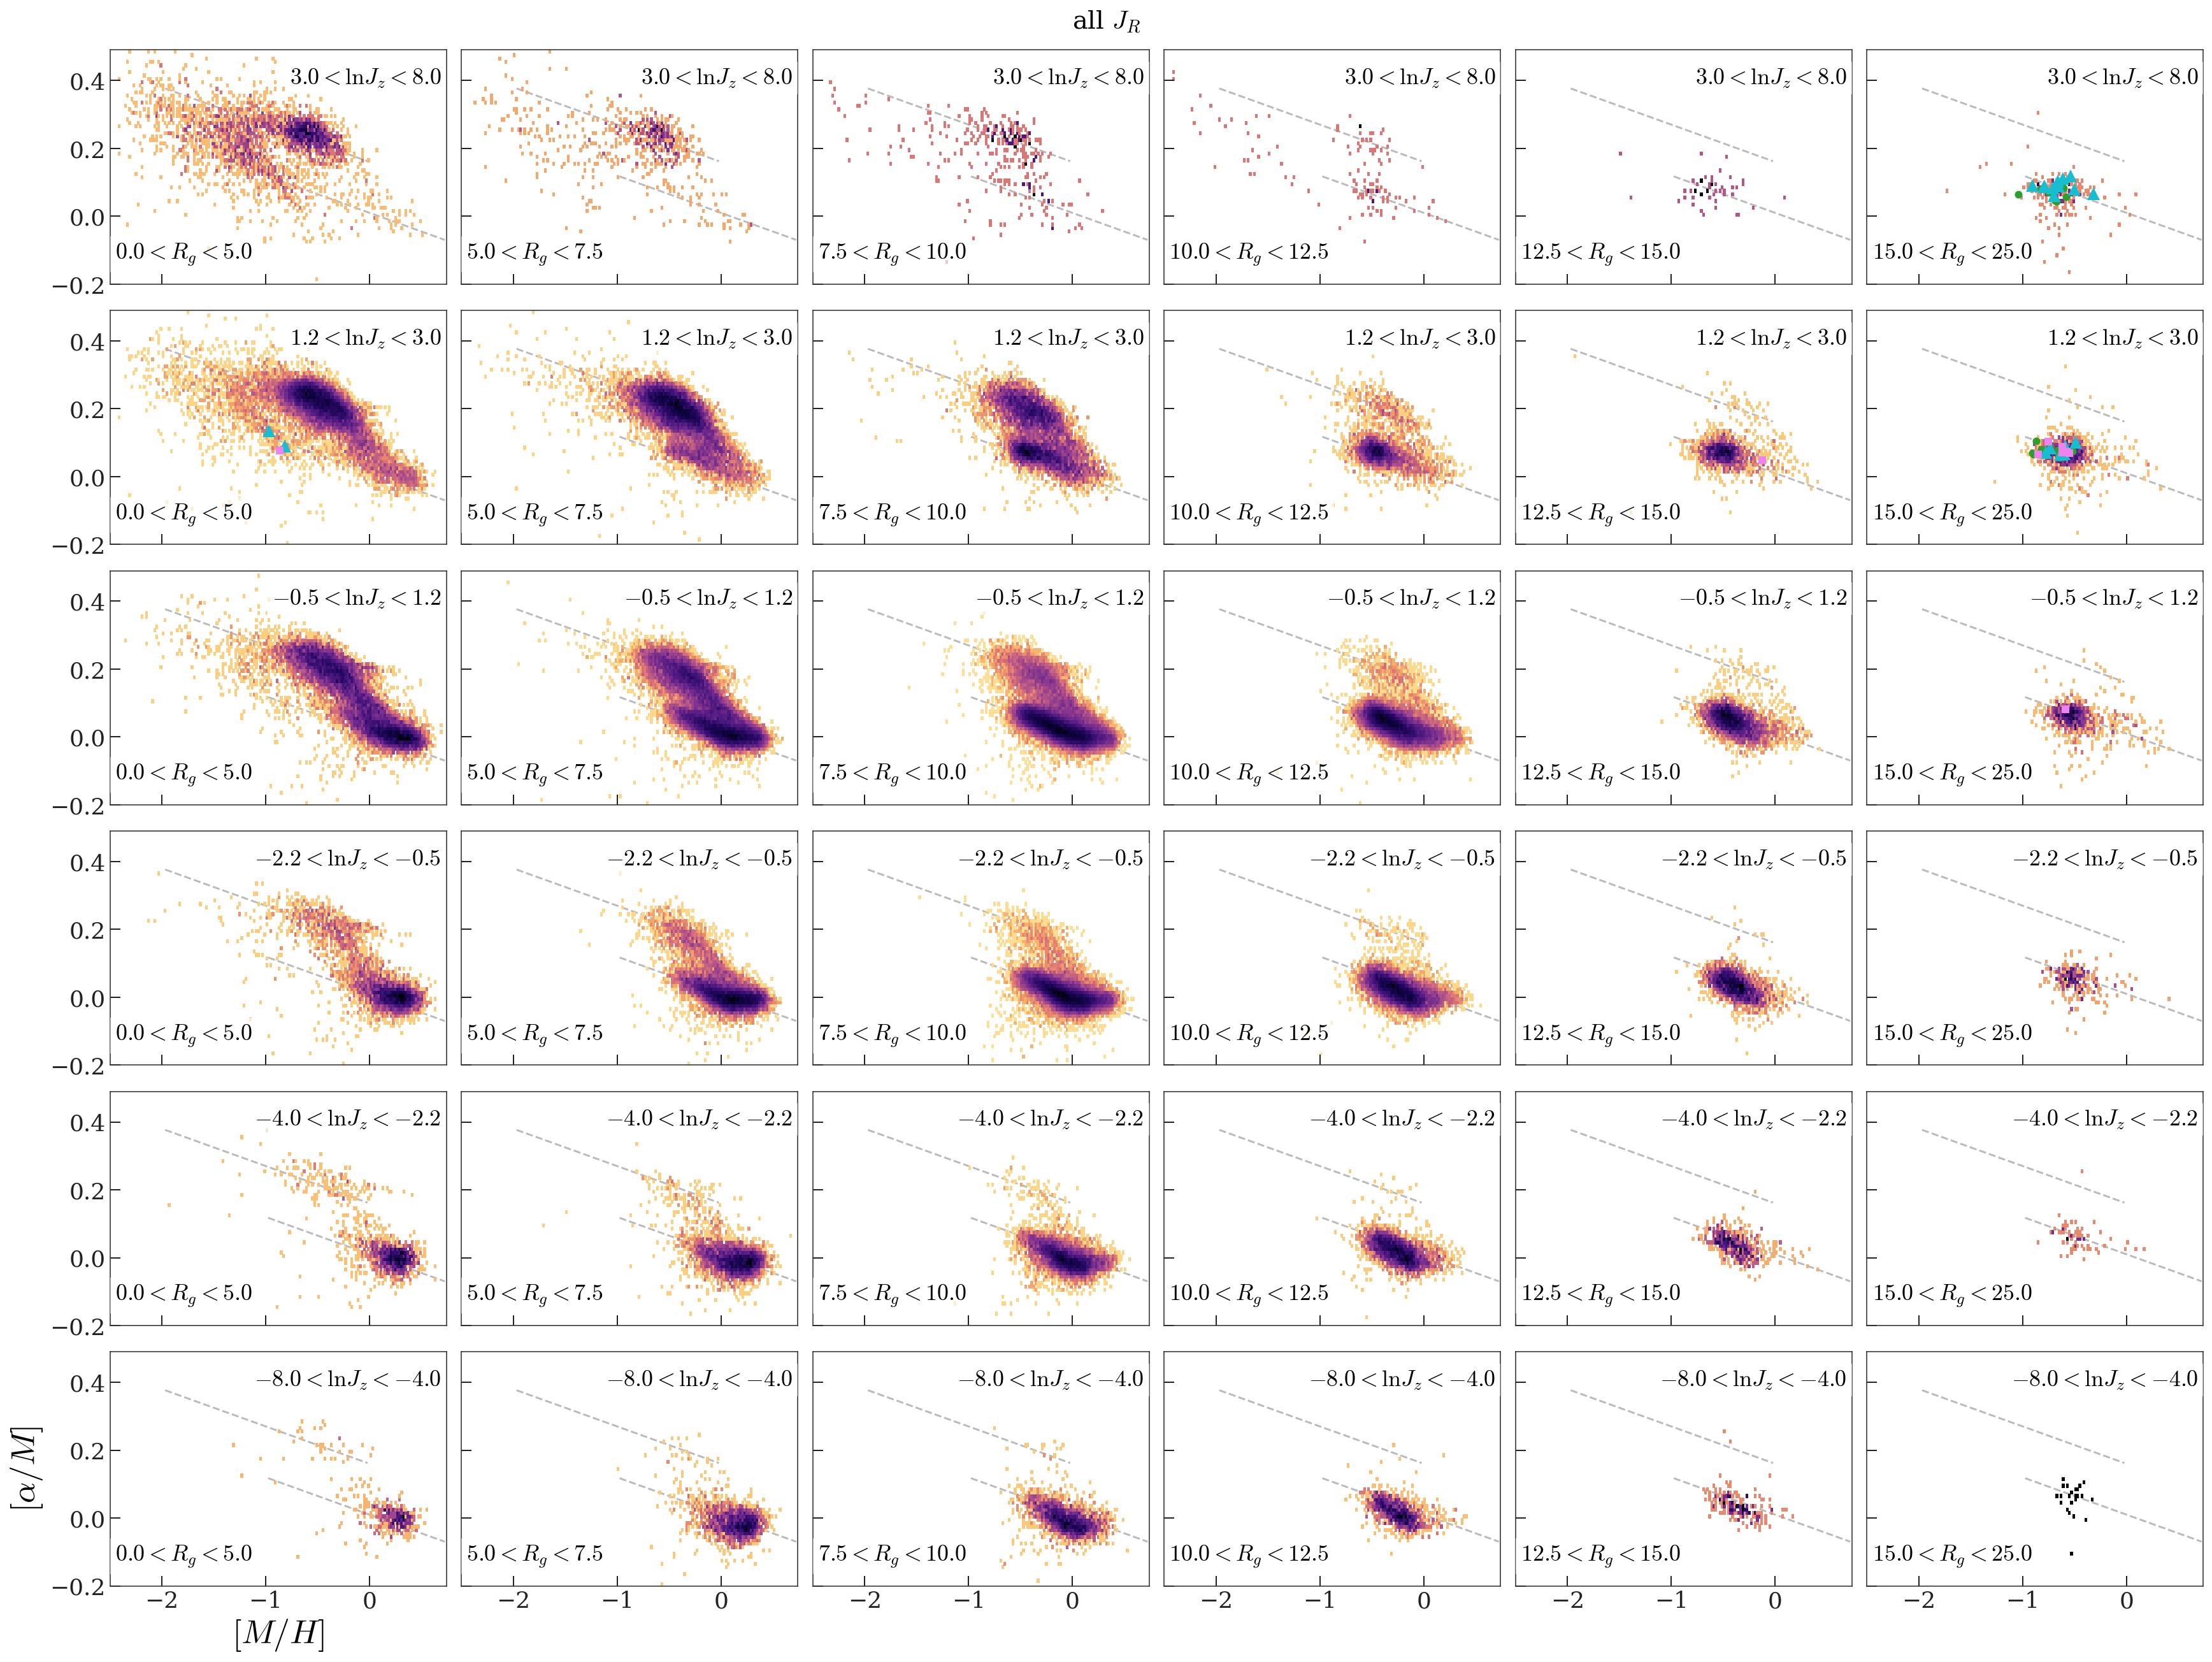

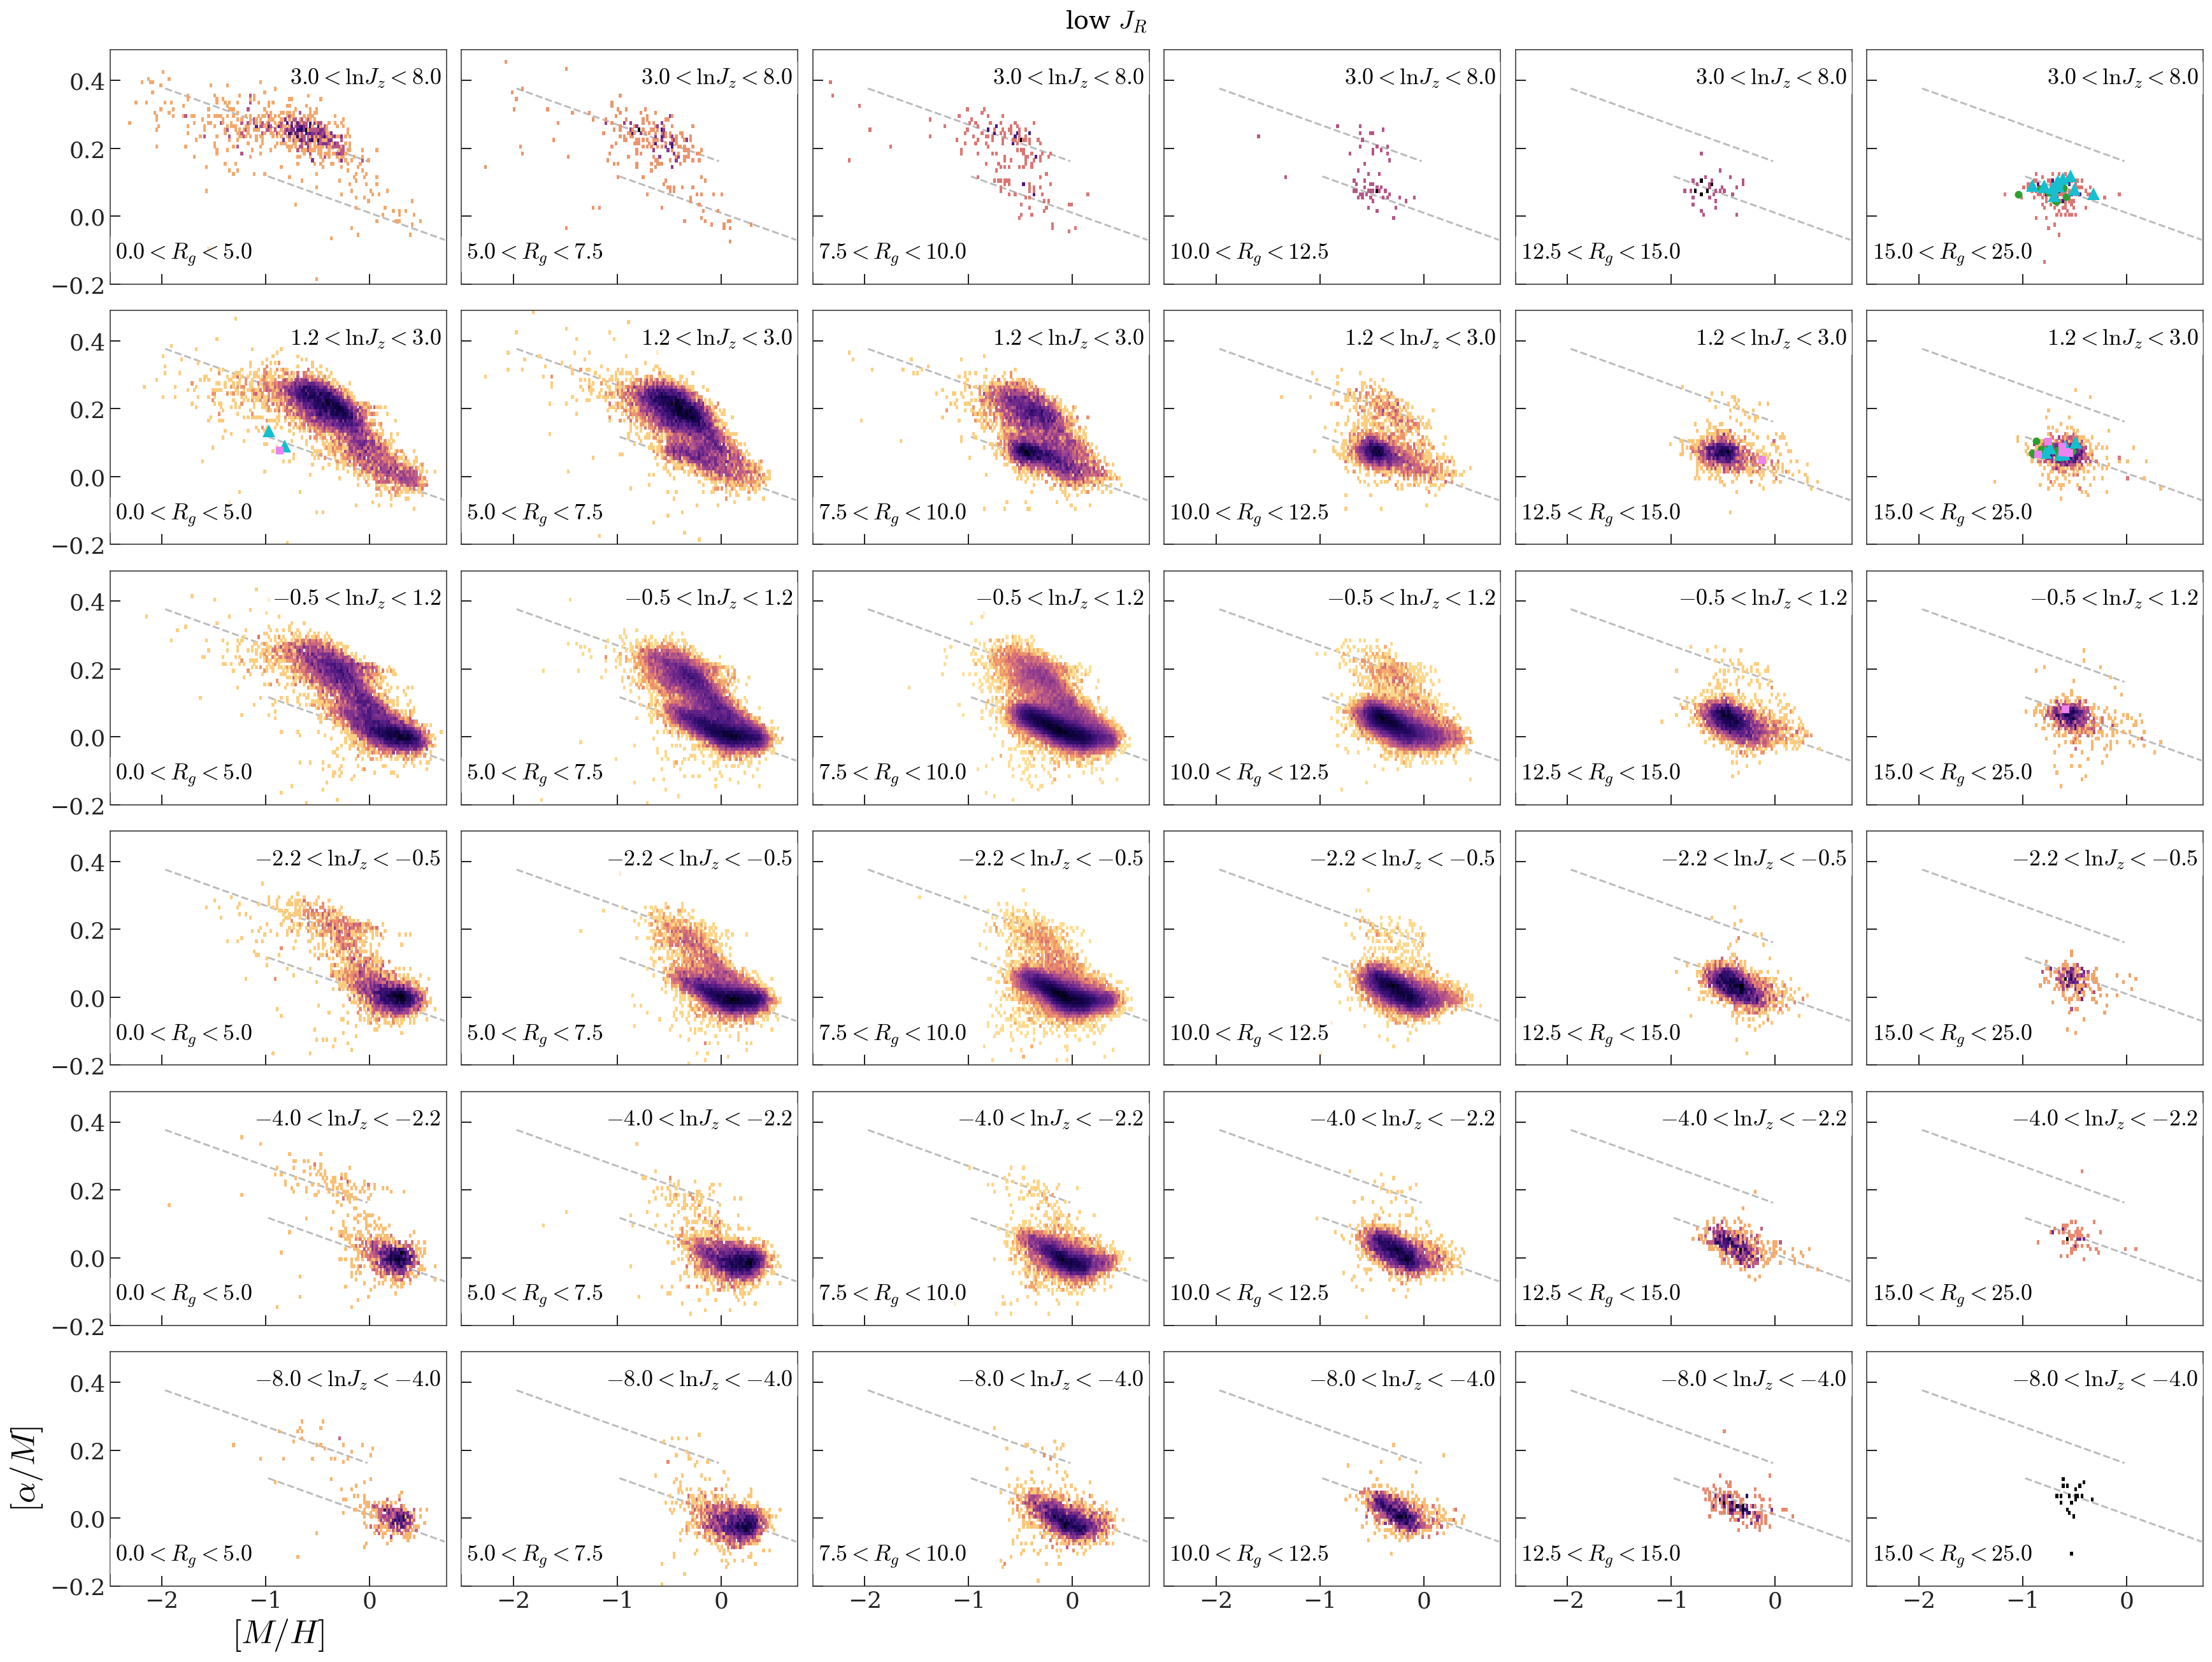

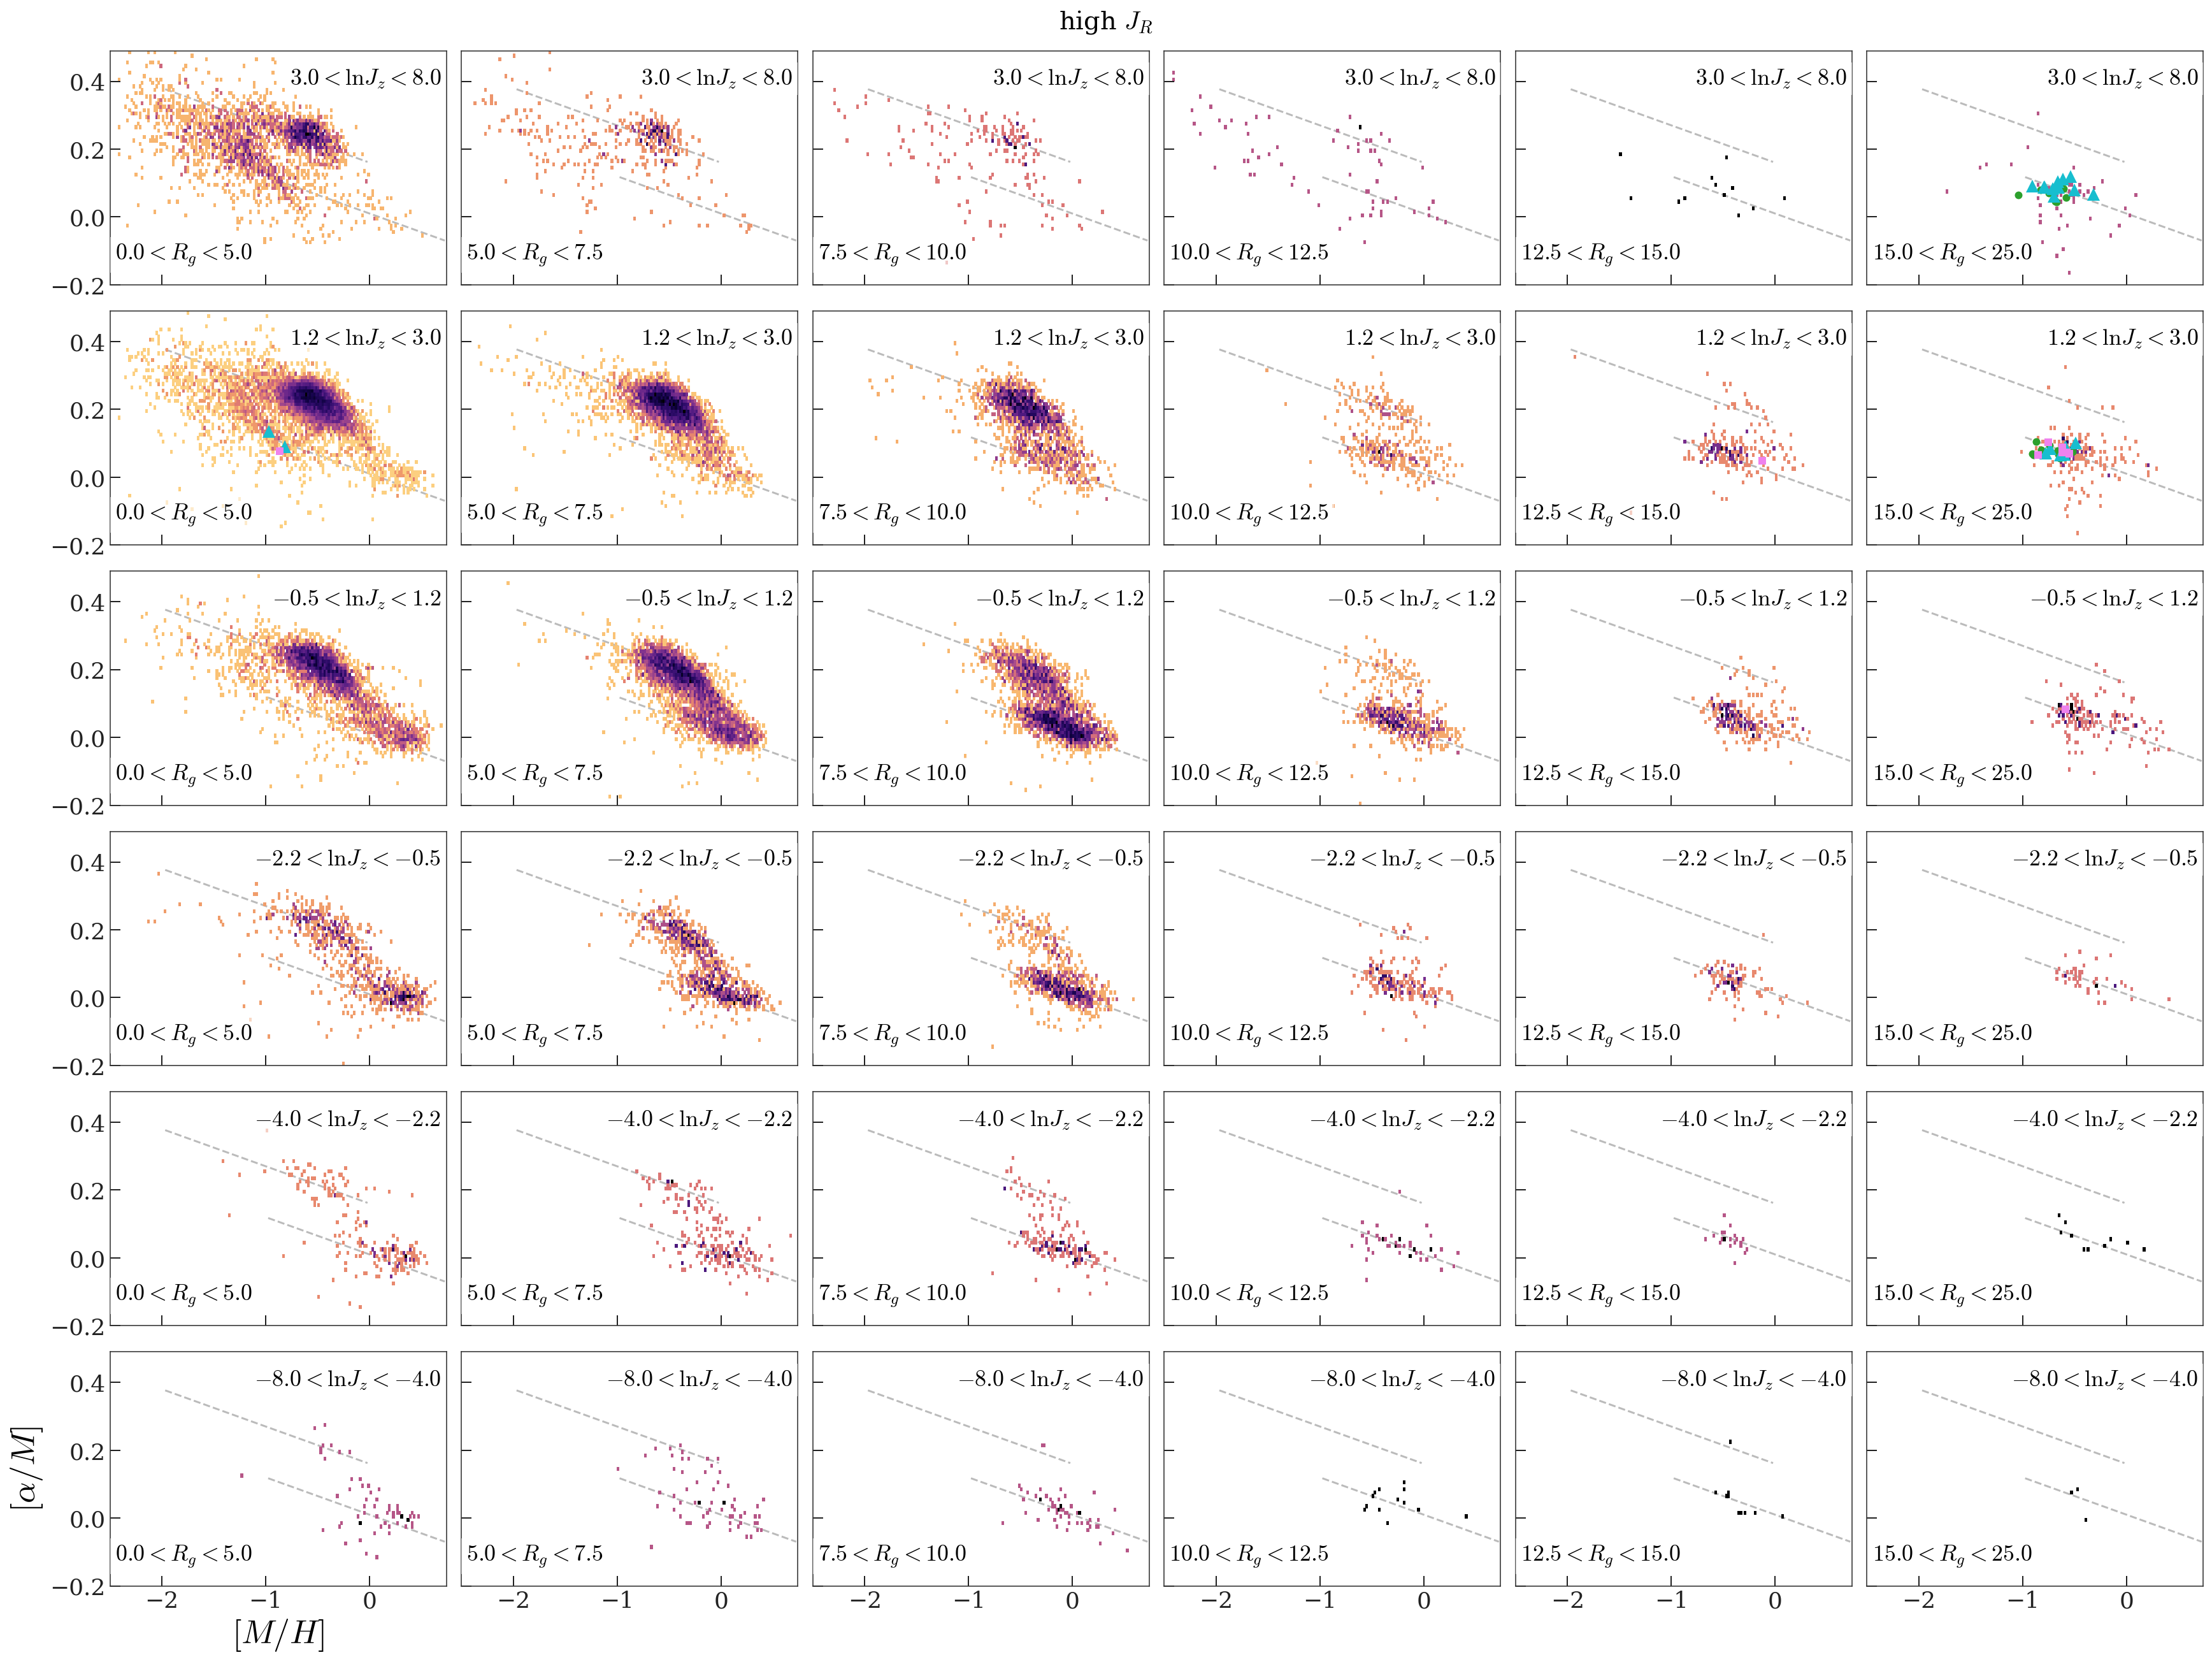

In [47]:
for title, extramask in zip(
        ['all $J_R$', 'low $J_R$', 'high $J_R$'],
        [None, jr < 10, jr >= 10]):
    
    if extramask is not None:
        mask = rgb_mask & extramask
    else:
        mask = rgb_mask
        
    fig, axes = make_panels(tbl,
                            Rg.to_value(u.kpc), logjz,
                            Rg_bins, logjz_bins,
                            r'R_g', r'\ln J_z',
                            extra_mask=mask,
                            point_masks=[triand_mask, a13_mask, gass_mask],
                            point_styles=[dict(ms=6, color='tab:green'),
                                          dict(ms=10, color='tab:cyan', marker='^'),
                                          dict(ms=6, color='violet', marker='s')],
                            flipud=True, cmap='hesperia_r')
    
    plot_mh_am_trends(axes.flat,
                      styles=[dict(color='#aaaaaa', lw=1.5, zorder=-10), 
                              dict(color='#aaaaaa', lw=1.5, zorder=-10)])
    
    fig.suptitle(title, fontsize=20)

## Low-alpha vs. high-alpha numbers

In [282]:
from scipy.stats import poisson

In [283]:
# this_rg_bins = np.arange(0, 20+1e-3, 1)
# this_rg_ctr = 0.5 * (this_rg_bins[:-1] + this_rg_bins[1:])

# for this_jz_mask in [logjz < -0.5,
#                      (logjz >= -0.5) & (logjz < 1.5),
#                      logjz >= 1.5]:
#     lo_alpha_N, _ = np.histogram(
#         Rg.value[low_alpha_mask & this_jz_mask], 
#         bins=this_rg_bins)
#     hi_alpha_N, _ = np.histogram(
#         Rg.value[hi_alpha_mask & this_jz_mask], 
#         bins=this_rg_bins)
    
#     plt.plot(this_rg_ctr, hi_alpha_N / lo_alpha_N)

# plt.yscale('log')

/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


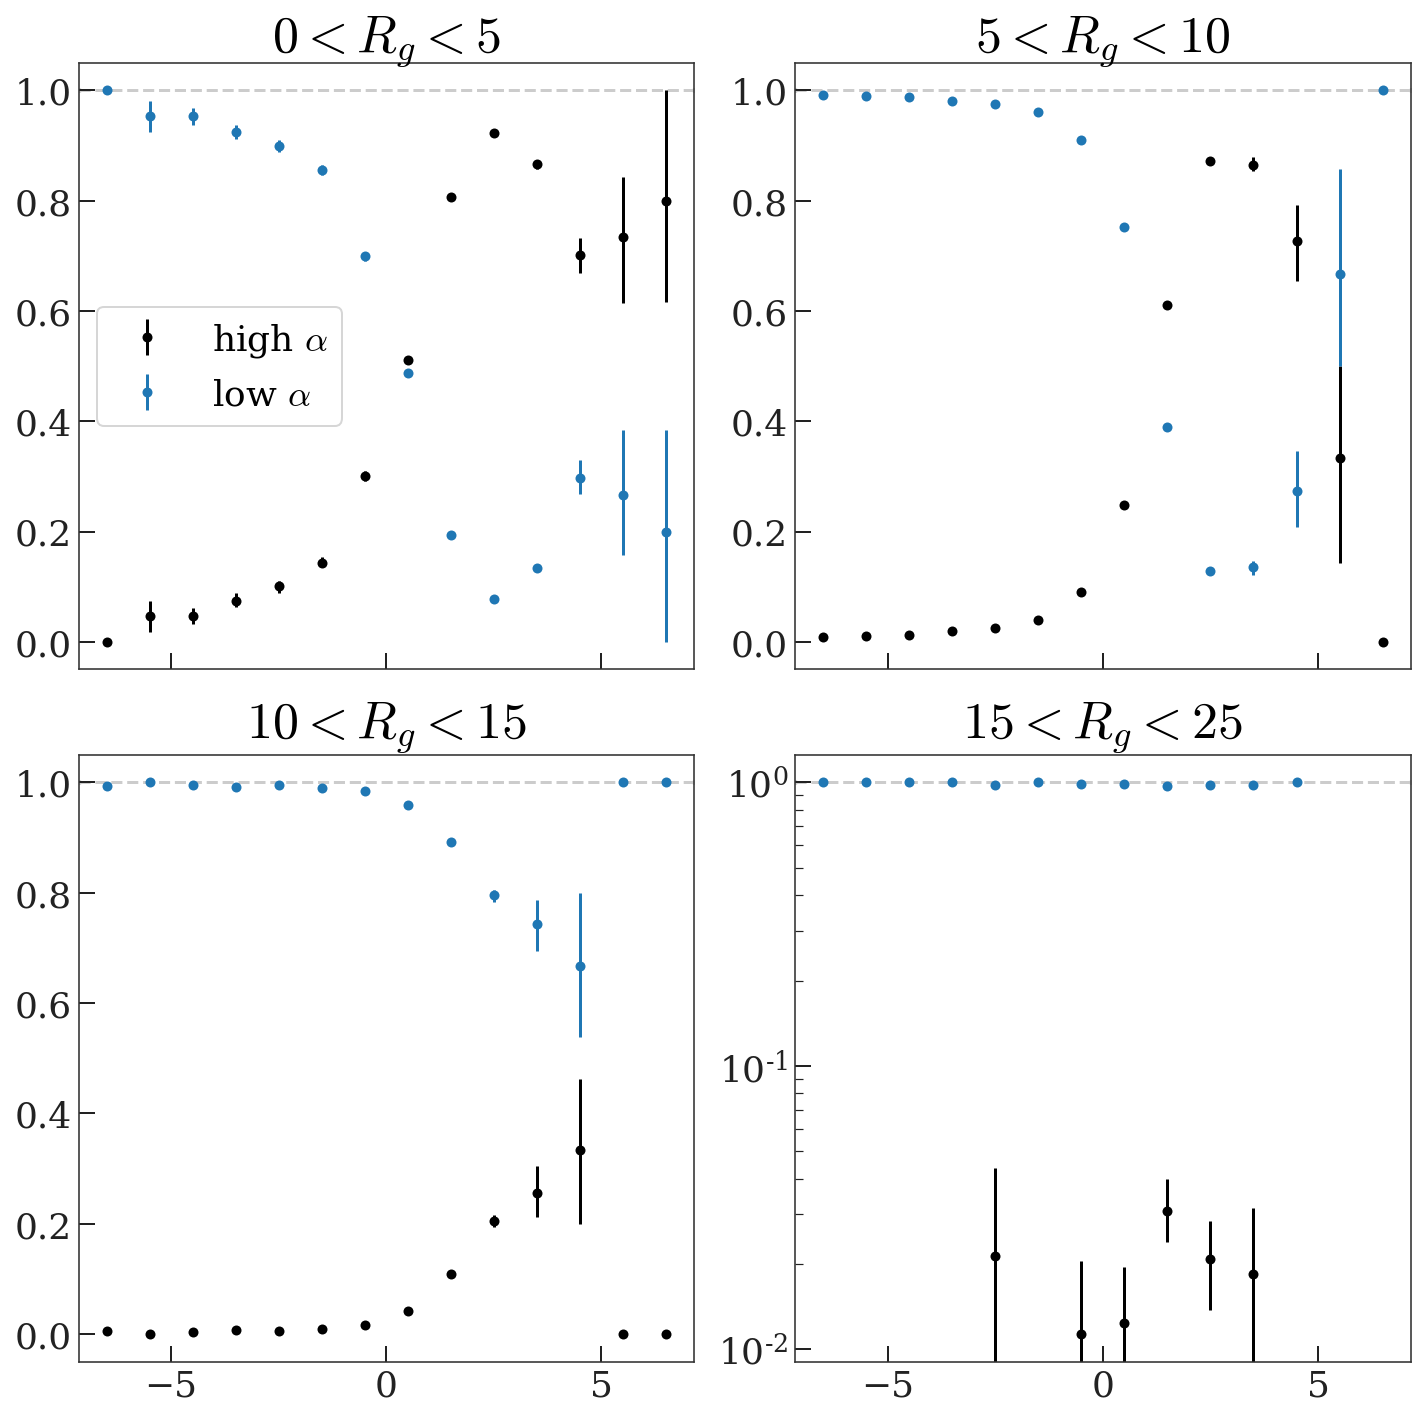

In [308]:
this_logjz_bins = np.arange(-7, 7+1e-3, 1)
this_logjz_ctr = 0.5 * (this_logjz_bins[:-1] + this_logjz_bins[1:])

this_Rg_bins = [(0, 5),
                (5, 10),
                (10, 15),
                (15, 25)]

fig, axes = plt.subplots(2, 2, figsize=(10, 10), 
                         sharex=True)


for ax, (this_l, this_r) in zip(axes.flat, this_Rg_bins):
    this_Rg_mask = (Rg.value >= this_l) & (Rg.value < this_r)
    
    lo_alpha_N, _ = np.histogram(
        logjz[rgb_mask & low_alpha_mask & this_Rg_mask], 
        bins=this_logjz_bins)
    hi_alpha_N, _ = np.histogram(
        logjz[rgb_mask & hi_alpha_mask & this_Rg_mask], 
        bins=this_logjz_bins)
    
#     all_N, _ = np.histogram(
#         logjz[rgb_mask & this_Rg_mask], 
#         bins=this_logjz_bins)
    # all_N = lo_alpha_N + hi_alpha_N
    
    hi_samples = poisson(hi_alpha_N).rvs(size=(256, len(hi_alpha_N)))
    lo_samples = poisson(lo_alpha_N).rvs(size=(256, len(lo_alpha_N)))
    all_N = hi_samples + lo_samples
    
    for name, samples in zip(['high', 'low'],
                             [hi_samples, lo_samples]):
        med = np.nanpercentile(samples / all_N, 50, axis=0)
        err1, err2 = np.nanpercentile(samples / all_N, [16, 84], axis=0)
        err1 = med - err1
        err2 = err2 - med

        ax.errorbar(this_logjz_ctr, 
                    med,
                    yerr=(err1, err2),
                    marker='o', ls='none', 
                    label=name+ r' $\alpha$')
    
    ax.set_title(f'${this_l:.0f} < R_g < {this_r:.0f}$')
    ax.axhline(1, zorder=-10, ls='--', color='#cccccc')

axes.flat[0].legend(loc='center left', fontsize=18)
    
ax.set_yscale('log')

# ax.set_xlabel(r'$\log J_z$')
# ax.set_ylabel(r'$N_{{\rm hi}-\alpha} / N_{{\rm lo}-\alpha}$')
# ax.legend(loc='upper left', fontsize=14)

fig.tight_layout()

## Jphi and Jz

In [48]:
# fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# # Jphi
# ax = axes[0]
# ax.hist(jphi, bins=np.arange(-2, 4, 0.05));

# Jphi_edges = np.concatenate(([-1.5], 
#                              np.arange(0.1, 2, 0.35),
#                              [2.5]))
# for l in Jphi_edges:
#     ax.axvline(l)
# ax.set_yscale('log')

# # Jz
# ax = axes[1]
# logjz = np.log(jz)
# ax.hist(logjz, bins=np.arange(-8, 8, 0.1));

# logJz_edges = np.concatenate(
#     ([-8], np.arange(-2.5, 2.5+1e-3, 1.2), [8]))
# for l in logJz_edges:
#     ax.axvline(l)
# # ax.set_yscale('log')

# # plot both:
# ax = axes[2]

# ax.hist2d(jphi, logjz, 
#           bins=(np.arange(-2, 4, 0.05), 
#                 np.arange(-8, 8, 0.1)),
#           norm=mpl.colors.LogNorm())
    
# for l in Jphi_edges:
#     ax.axvline(l)
# for l in logJz_edges:
#     ax.axhline(l)
    
# fig.tight_layout()

# jphi_bins = edges_to_bins(Jphi_edges)
# logjz_bins = edges_to_bins(logJz_edges)
# print(len(jphi_bins), len(logjz_bins))

In [49]:
# fig, axes = make_panels(tbl,
#                         jphi, logjz,
#                         jphi_bins, logjz_bins,
#                         r'J_\phi', r'\ln J_z',
#                         extra_mask=rgb_mask,
#                         flipud=True, cmap='hesperia_r')
# plot_mh_am_trends(axes.flat)

## Vasiliev plot

In [201]:
E = w0.energy(mw_pot)
phi = mw_pot.energy(w0)
# Lcirc = np.sqrt((E - phi) * 2 * Rg**2)
Lcirc = np.sqrt((E - phi) * 2 * w0.spherical.distance**2)

In [212]:
eta = (-tbl['J_phi'] / Lcirc).decompose()
# eta = (-Lz / Lcirc).decompose()
xsi = ((tbl['J_z'] - tbl['J_R']) / Lcirc).decompose()

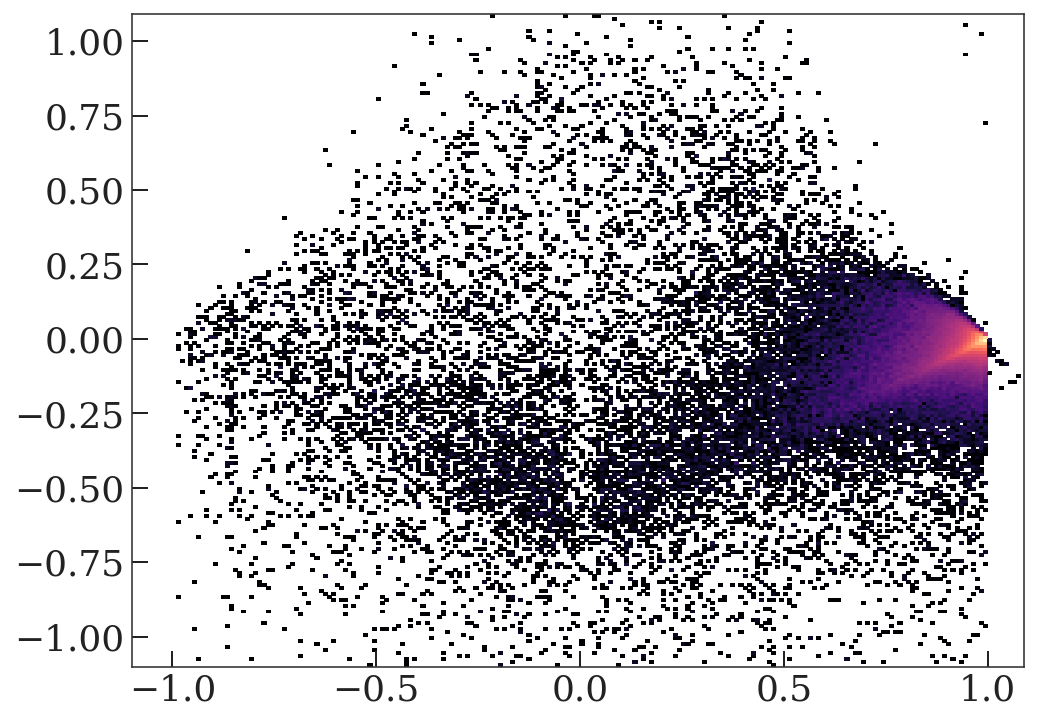

In [213]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.hist2d(eta[rgb_mask], xsi[rgb_mask], 
          bins=np.arange(-1.1, 1.1, 0.01), 
          norm=mpl.colors.LogNorm());

## R vs. Vphi

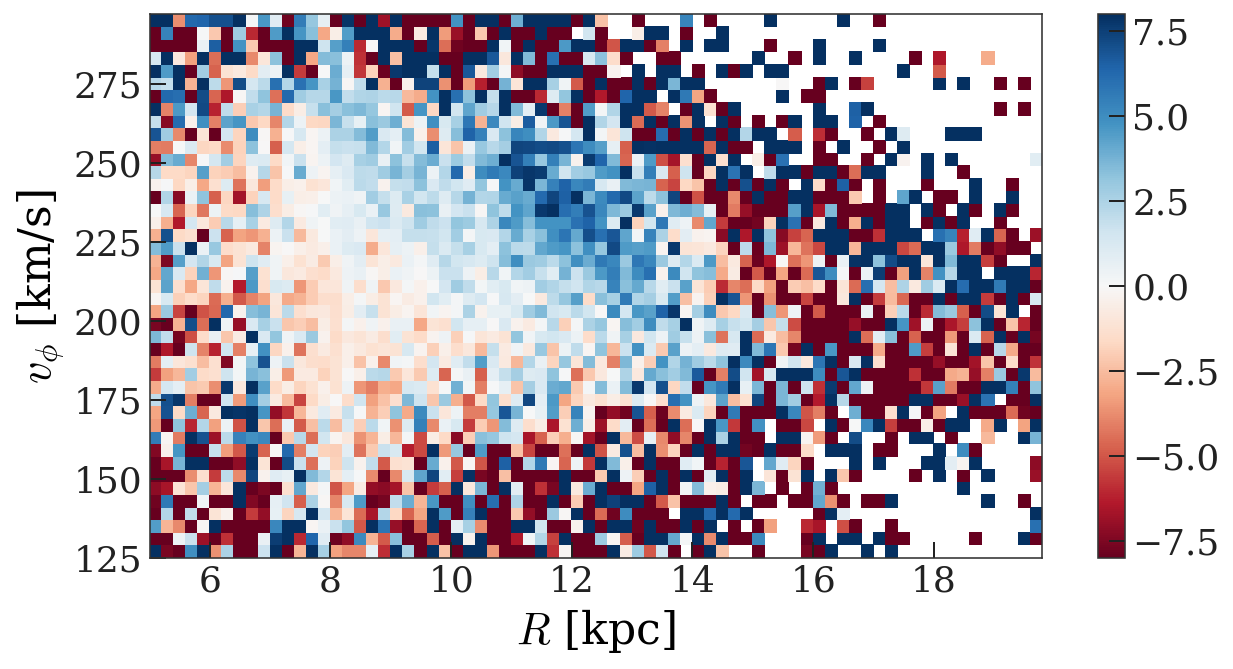

In [53]:
stat = binned_statistic_2d(R.value, -vphi.to_value(u.km/u.s),
                           vz.to_value(u.km/u.s),
                           bins=(np.arange(5, 20, 0.2),
                                 np.arange(125, 300, 4)))

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
cs = ax.pcolormesh(
    stat.x_edge, stat.y_edge, stat.statistic.T,
    vmin=-8, vmax=8, 
    cmap='RdBu')
fig.colorbar(cs)

ax.set_xlabel('$R$ [kpc]')
ax.set_ylabel(r'$v_\phi$ [km/s]')

fig.set_facecolor('w')

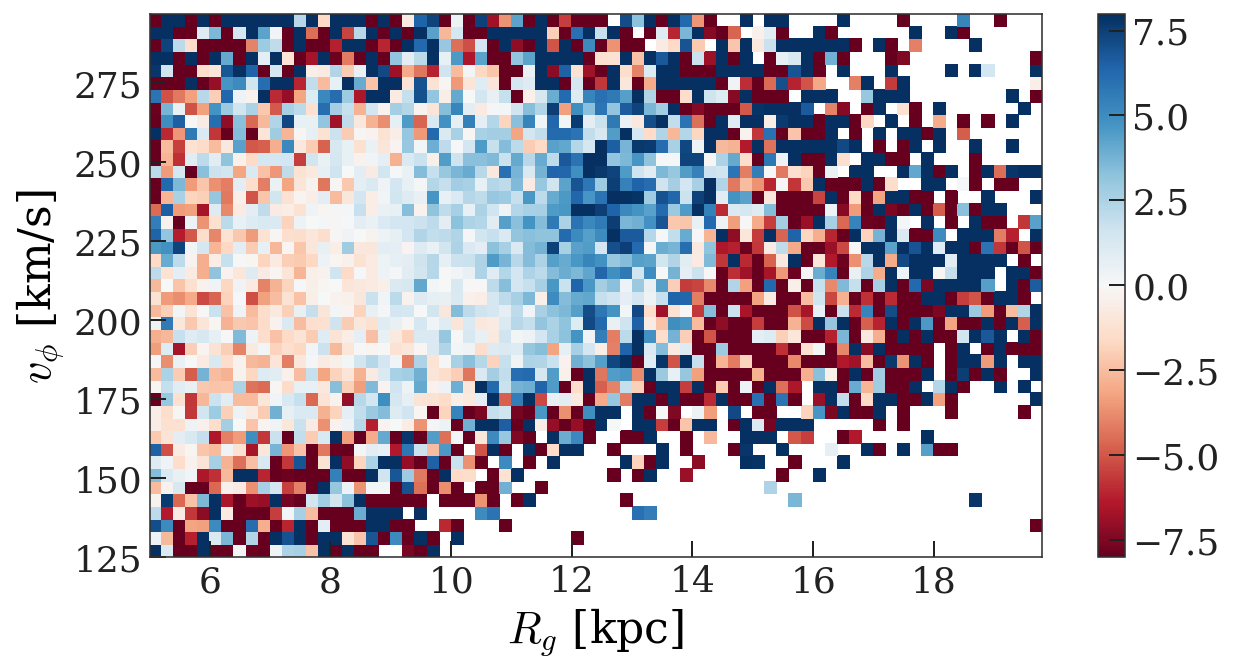

In [54]:
stat = binned_statistic_2d(Rg.value[rgb_mask], 
                           -vphi.to_value(u.km/u.s)[rgb_mask],
                           vz.to_value(u.km/u.s)[rgb_mask],
                           bins=(np.arange(5, 20, 0.2),
                                 np.arange(125, 300, 4)))

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
cs = ax.pcolormesh(
    stat.x_edge, stat.y_edge, stat.statistic.T,
    vmin=-8, vmax=8, 
    cmap='RdBu')
fig.colorbar(cs)

ax.set_xlabel('$R_g$ [kpc]')
ax.set_ylabel(r'$v_\phi$ [km/s]')

fig.set_facecolor('w')

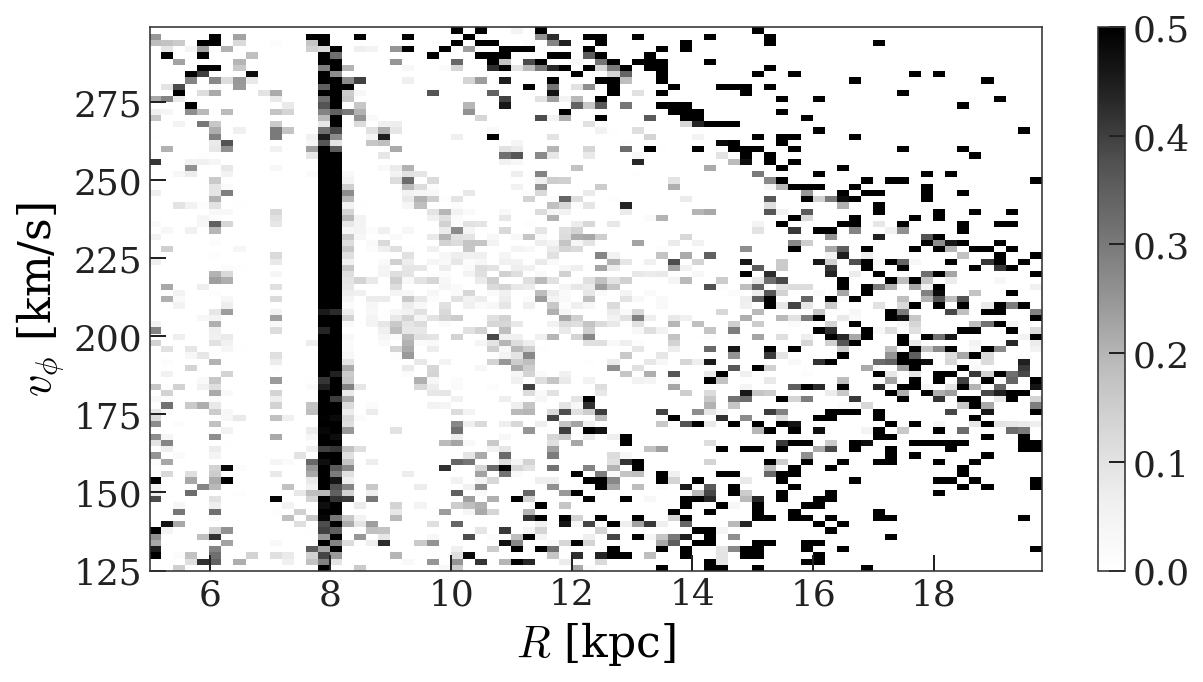

In [55]:
stat = binned_statistic_2d(R[rgb_mask], 
                           -vphi.to_value(u.km/u.s)[rgb_mask],
                           vz.to_value(u.km/u.s)[rgb_mask],
                           bins=(np.arange(5, 20, 0.2),
                                 np.arange(125, 300, 2)),
                           statistic='count')

H = stat.statistic
H_sm = gaussian_filter(H, sigma=3)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
cs = ax.pcolormesh(
    stat.x_edge, stat.y_edge, 
    ((H - H_sm)/H_sm).T,
    vmin=0, vmax=0.5, cmap='Greys')
fig.colorbar(cs)

ax.set_xlabel('$R$ [kpc]')
ax.set_ylabel(r'$v_\phi$ [km/s]')

fig.set_facecolor('w')

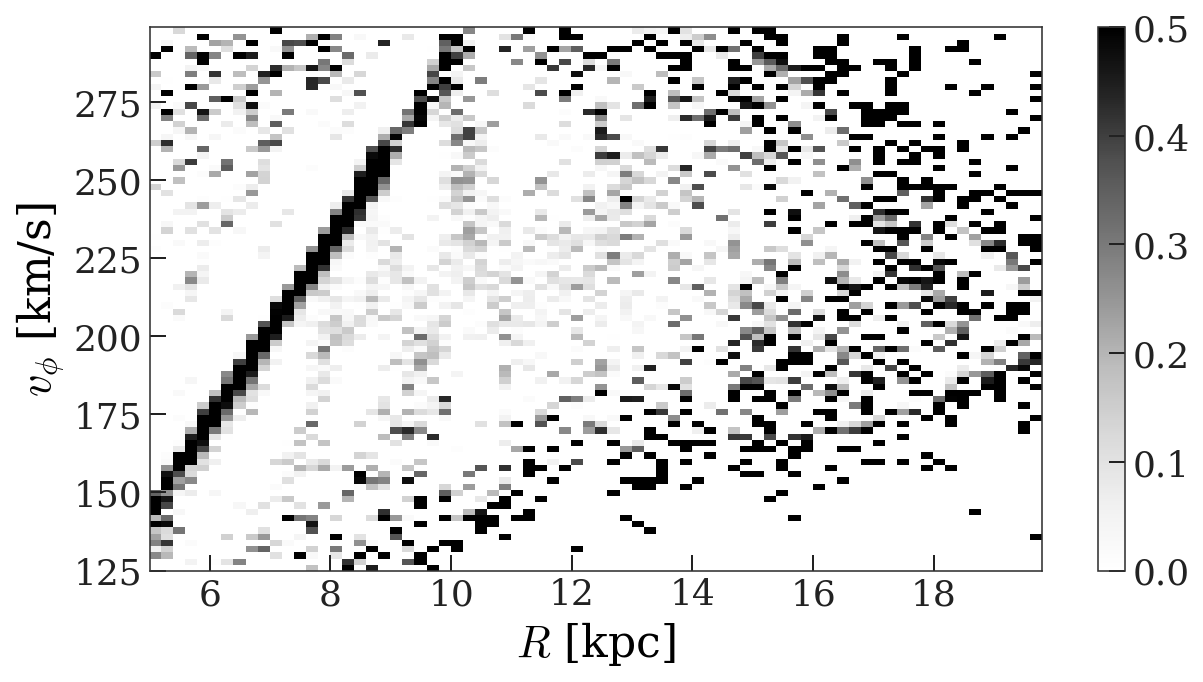

In [56]:
stat = binned_statistic_2d(Rg.value[rgb_mask], 
                           -vphi.to_value(u.km/u.s)[rgb_mask],
                           vz.to_value(u.km/u.s)[rgb_mask],
                           bins=(np.arange(5, 20, 0.2),
                                 np.arange(125, 300, 2)),
                           statistic='count')

H = stat.statistic
H_sm = gaussian_filter(H, sigma=3)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
cs = ax.pcolormesh(
    stat.x_edge, stat.y_edge, 
    ((H - H_sm)/H_sm).T,
    vmin=0, vmax=0.5, cmap='Greys')
fig.colorbar(cs)

ax.set_xlabel('$R$ [kpc]')
ax.set_ylabel(r'$v_\phi$ [km/s]')

fig.set_facecolor('w')

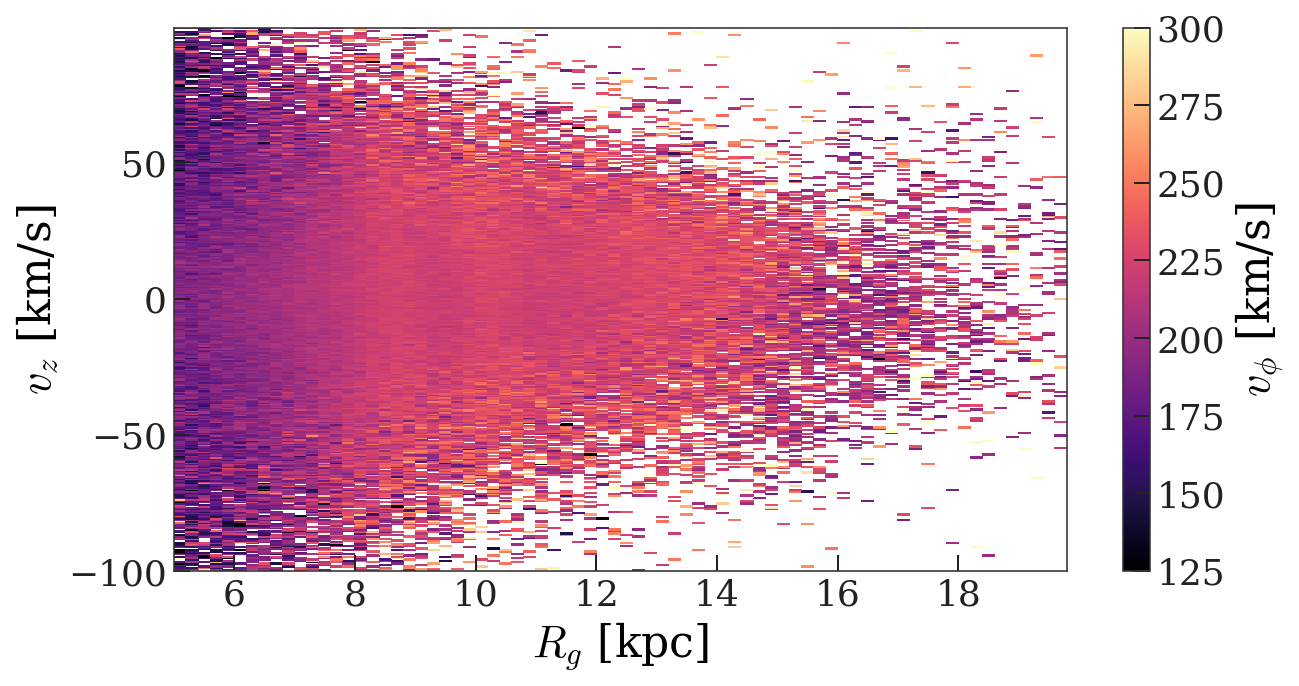

In [61]:
stat = binned_statistic_2d(Rg.value[rgb_mask], 
                           vz.to_value(u.km/u.s)[rgb_mask],
                           -vphi.to_value(u.km/u.s)[rgb_mask],
                           bins=(np.arange(5, 20, 0.2),
                                 np.arange(-100, 100, 0.5)))

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
cs = ax.pcolormesh(
    stat.x_edge, stat.y_edge, stat.statistic.T,
    vmin=125, vmax=300, 
    cmap='magma')
cb = fig.colorbar(cs)
cb.set_label(r'$v_\phi$ [km/s]')

ax.set_xlabel('$R_g$ [kpc]')
ax.set_ylabel(r'$v_z$ [km/s]')

fig.set_facecolor('w')